# Stock Market Predictions with LSTM

Datacamp Tutorial: https://www.datacamp.com/community/tutorials/lstm-python-stock-market

In this tutorial, you will see how you can use a time-series model known as Long Short-Term Memory (LSTM) models. LSTM models are powerful, especially retaining long-term memory, by their design as you will see later. You'll tackle the following topics in this tutorial:

- Understand why should you need to be able to predict stock prices / movements
- Download the data - You will be using stock market data gathered from Yahoo finance
- Split train-test data and data normalization
- See few averaging techniques that can be used for one-step ahead predictions
- Motivate and briefly discuss an LSTM model as it allows to predict more than one-step ahead 
- Predict and visualize future stock market with current data
- Final remarks

## Why Do You Need Time Series Models?

You would like to model this stock prices correctly, so as a stock buyer you can reasonably decide when to buy stocks and when to sell them to gain profit. This is where time series modelling comes in. You need good machine learning models that can look at the history of a sequence of data and correctly predict the future elements of the sequence are going to be.

**Warning**: Stock market prices are highly unpredictable and volatile. This means that there are no consistent patterns in the data that allows us to model stock prices over time near-perfectly. Don't take it from me, take it from Princeton University economist Burton Malkiel, who argues in his 1973 book, "A Random Walk Down Wall Street," that if the market is truly efficient and a share price reflects all factors immediately as soon as they're made public, a blindfolded monkey throwing darts at a newspaper stock listing should do as well as any investment professional.

However, let's not go all the way believing that this is just a stochastic / random process and no hope for machine learning. Let's see if you can at least model the data, so that the predictions you make correlate with the actual behavior of the data. In other words, you don't need the exact stock values of the future, but the stock price movements (that is, if it is going to rise of fall in the near future).

In [ ]:
pip install tensorflow==1.15.5

     |████████████████████████████████| 110.5MB 100kB/s 
     |████████████████████████████████| 20.1MB 1.3MB/s 
     |████████████████████████████████| 3.8MB 32.3MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 2.9MB 32.1MB/s 
     |████████████████████████████████| 512kB 59.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7557 sha256=6ead7b69d6bee0be2285031f1de071aa2c2106f53448ec766a6f62c5c31cb7d2
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<

In [218]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json 
import os
import numpy as np
#import tensorflow as tf # This code has been tested with TensorFlow 1.6
import tensorflow.compat.v1 as tf #SM: Import version 1 to prevent errors
tf.disable_v2_behavior()
from sklearn.preprocessing import MinMaxScaler

## Mount Google Drive 

In [219]:
currentWorkingDir = !pwd
defaultWorkingDir = "/content"

if ( currentWorkingDir[0] == defaultWorkingDir ):
  from google.colab import drive

  drive.mount('/content/drive')
      
  %cd "/content/drive/My Drive/Colab Notebooks/stock_portfolio"
else:
  print("Currenting running app from: ")
  !pwd


Currenting running app from: 
/content/drive/My Drive/Colab Notebooks/stock_portfolio


## 2. Download data

You present code for using data from,

1. Alpha Vantage. Before you start, however, you will first need an API key, which you can obtain for free [here](https://www.alphavantage.co/support/#api-key). After that, you can assigned that key to the `api_key` variable.

2. Use the data from [this page](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs). You will need to copy the *Stocks* folder in the zip file to your project home folder.

Stock prices come in several different flavours. They are,
* Open: Opening stock price of the day
* Close: Closing stock price of the day
* High: Highest stock price of the data
* Low: Lowest stock price of the day

### Getting Data from Alphavantage
You will first load in the data from Alpha Vantage. Since you're going to make use of the American Airlines Stock market prices to make your predictions, you set the ticker to `"AAL"`. Additionally, you also define a `url_string`, which will return a JSON file with all the stock market data for American Airlines within last 20 years, and a `file_to_save`, which will be the file to which you save the data. You'll use the `ticker` variable that you defined beforehand to help name this file. 

Next, you're going to specify a condition: if you haven't already saved data, you will go ahead and grab the data from the URL that you set in `url_string`; You'll store the date, low, high, volume, close, open values to a pandas DataFrame `df` and you'll save it to `file_to_save`. However, if the data is already there, you'll just load it from the CSV. 

### Getting Data from Kaggle
Data found in Kaggle is a collection of csv files and you don't have to do any preprocessing. So you directly load data into a Panda dataframe.


In [274]:
# ====================== Loading Data from Kaggle ==================================
# You will be using HP's data. Feel free to experiment with other data. 
# But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
df = pd.read_csv(os.path.join('Stocks','ccc.csv'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
print('Loaded data from the Kaggle repository')

Loaded data from the Kaggle repository


### Data Exploration

Here you will print the data you collected in to the dataframe. You also will make sure that the data is sorted by the date. Because the order of data is crucial in time series modelling. 

In [275]:
# Sort dataframe by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,Open,High,Low,Close
0,1995-01-03,3.80,3.8,3.80,3.85
1,1995-01-05,3.85,4.0,4.00,4.05
2,1995-01-10,4.05,4.5,4.35,4.55
3,1995-01-12,4.55,5.6,5.60,5.60
4,1995-01-17,5.60,5.0,5.00,5.00


#### Data Visualization
Now let's see what sort of data you have at our hand. You want data with various patters occurring over time.

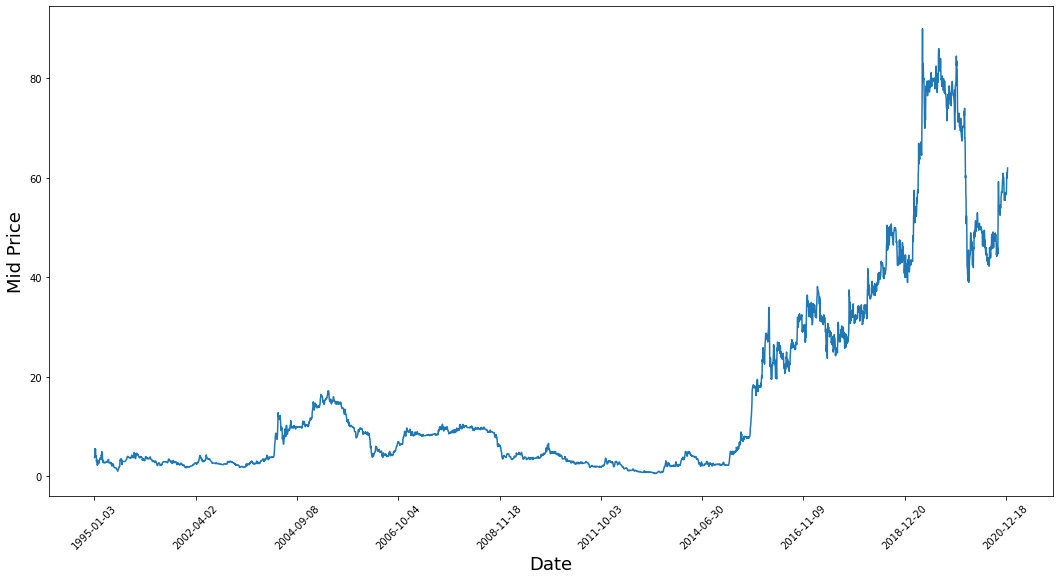

In [276]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

This graph already says a lot of things. The Specific reason I picked this company over others is that this graph is bursting with different behaviors of stock prices over time. This will make the learning more robust as well as give us a change to test how good the predictions are for a variety of situations. 

Another thing to notice is that the values close to 2017 are much higher and highly fluctuating than the values close to 1970s. Therefore you need to make sure that the data behaves in similar value ranges throughout the time frame. You will take care of this during the *data normalization*.


## Breaking Data to Train and Test and Normalizing Data

You will use the mid price calculated by taking the average of the highest and lowest recorded prices on a day

In [277]:
# First calculate the mid prices from the highest and lowest 
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0

Now you can break the train data and test data. Train data will be the first 11000 data points of the time series and rest will be test data.

In [278]:
train_data = mid_prices[:4000]
test_data = mid_prices[4000:]

Now you need to define a scaler to normalize data `MinMaxScalar` scales all the data to be in the region of 0 and 1. You also reshape the train and test data to be in the shape `[data_size, num_features]`.

In [279]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data w.r.t training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

Due to the observation you made earlier, that is, different time periods of data has different value ranges, you normalize data by breaking the full series to windows. If not the earlier data will all be close to 0 and will not add much value to learning. Here you choose a window size of 2500. When choosing the window size make sure it will not be too small. Because when performing windowed-normalization, it can introduce a break at the very end of each window, as each window is normalized independently. In our exampe, 4 data points will be affected by this. But given you have 11000 data points, 4 points will not cause any issue

In [281]:
# Train the Scaler with training data and smooth data 
smoothing_window_size = 1000
for di in range(0,3000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data 
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

Reshape data back to the shape of `[data_size]`

In [270]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

You now smooth data using exponential moving average. This helps us to get rid of the inherent raggedness of the data in stock prices and preduce a smoother curve. Note that you should only smooth training data. 

In [282]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(4000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

## One-Step Ahead Prediction via Averaging 

Averaging mechanisms allows us to predict (often one time step ahead) by representing the future stock price as an average of the previously observed stock prices. Doing this for more than one time step can produce quite bad results. You will look at two averaging techniques below; standard averaging and exponential moving average. You will evaluate both qualitatively (visual inspection) and quantitatively (mean squared error) the results produced by two algorithms.

Mean squared error (MSE) can be calculated by taking the mean squared error between the true value at one step ahead and the predicted value and averaging it over all the predictions.

### Standard Average

Let us understand the difficulty of this problem first by trying to model this as an average calculation problem. That is first you will try to predict the future stock market prices (for example, $x_{t+1}$) as an average of the previously observed stock market prices within a fixed size window (for example, $x_{t-N},\ldots,x_{t}$) (say previous 100 days). Thereafter you will try a bit more fancier "exponential moving average" method and see how well that does. Then you will move on to the "holy-grail" of time-series prediction; Long Short-Term Memory models.

First you will see how normal averaging works. That is you say,

$x_{t+1} = 1/N \sum_{i=t-N}^{t} x_i$

In other words, you say the prediction at $t+1$ is the average value of all the stock prices you observed withing a window of $t$ to $t-N$.

In [283]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):
    
    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']
        
    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00689



Below you look at the averaged results. Well, it follows the actual behavior of stock quite closely. Next you look at a more accurate one-step prediction method

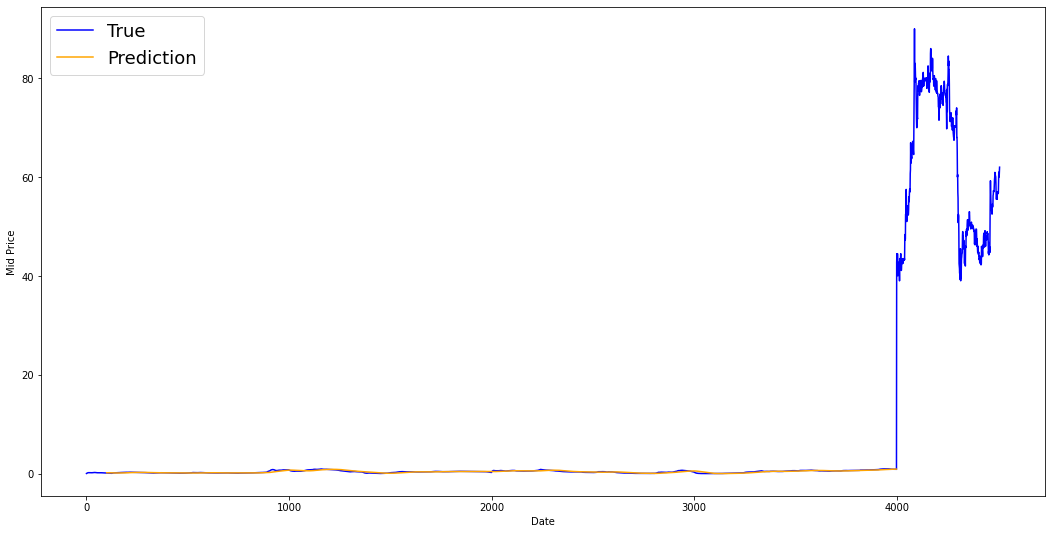

In [284]:

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

So what does the above graphs (and the MSE) say? It seems that it is not too bad of a model for very short predictiosn (one day ahead). Given that stock prices don't change from 0 to 100 over night, this behavior is sensible. Next you look at a fancier averaging technique known as exponential moving average.

### Exponential Moving Average (Replicating Some of the so-called amazing stock market prediction learning)

You might have seen some articles in the internet using very complex models and predicting almost the exact behavior of the stock market. But **beware!** all of them I have seen are just optical illusions and not due to learning something useful. You will see below how you can replicate that behavior with a simple averaging method. 

In the exponential moving average method, you calculate $x_{t+1}$ as,

* $x_{t+1} = EMA_{t} = \gamma \times EMA_{t-1} + (1-\gamma) x_t$ where $EMA_0 = 0$ and $EMA$ is the exponential moving average value you maintain over time.

The above equation basically calulates the exponential moving averag from $t+1$ time step and uses that as the one step ahead prediction. $\gamma$ decides what is the contribution of the most recent prediction to the EMA. For example, a $\gamma=0.1$ gets only 10% of the current value into the EMA. Because you take only a very small fraction of the most recent, it allows to preserve much older values you saw very early in the average. Let us look how good this looks when used to predict one-step ahead.



In [285]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):
    
    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00005


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


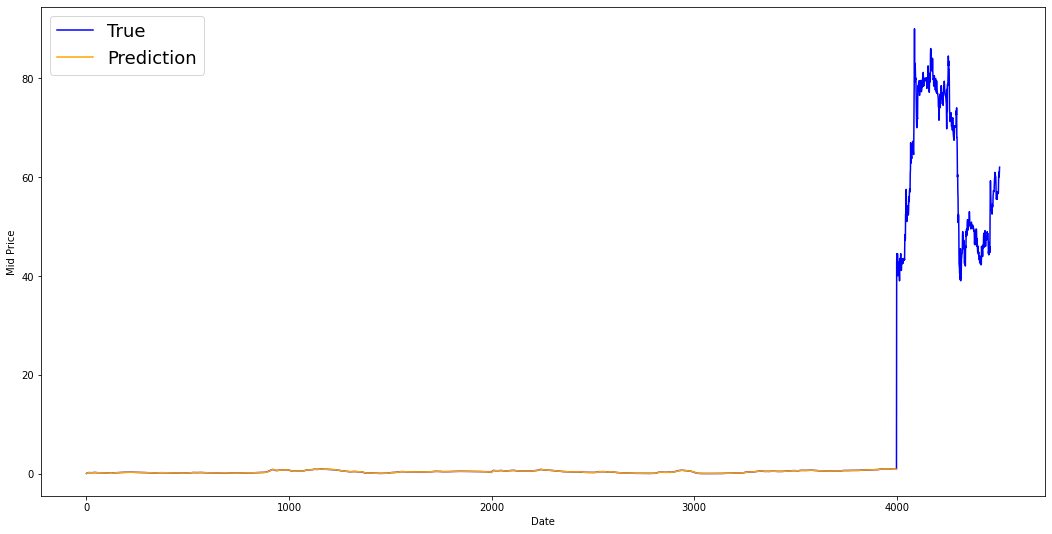

In [286]:

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

### If Exponential Moving Average is this Good, Why do You Need Better Models?

You see that it fits a perfect line that follows the True distribution (and justified by the very low MSE). Practically speaking, you can't do much with just the stock market value of the next day. Personally what I'd like is not the exact stock market price for the next day, but *would the stock market prices go up or down in the next 30 days*. Try to do this, and you will expose the incapability of EMA method. 

Let us try to make predictions in windows (say you predict next 2 days window, instead of just next day). Then you will realize how wrong EMA can go. Let us understand this through an example.

### Think About What Happens when You Need to Predict More Than One Step into the Future
To make things concrete, let us assum values, say $x_t=0.4$, $EMA=0.5$ and $\gamma = 0.5$
* Say you get the output with the following equation
 * $x_{t+1} = EMA_t = \gamma \times EMA_{t-1} + (1-\gamma) x_t$
 * So you have $x_{t+1} = 0.5 \times 0.5 + (1-0.5) \times 0.4 = 0.45$
 * So $x_{t+1} = EMA_t = 0.45$
* So the next prediction $x_{t+2}$ becomes,
 * $x_{t+2} = \gamma \times EMA_t + (1-\gamma) x_{t+1}$
 * Which is $x_{t+2} = \gamma \times EMA_t + (1-\gamma) EMA_t = EMA_t$
 * Or in this example, $x_{t+2} = x_{t+1} = 0.45 $
 
So no matter how many steps you predict in to the future, you'll keep getting the same answer for all the future prediction steps. 

One solution you have that will output useful information is to look at **momentum-based algorithms**. They make predictions based on whether the past recent values were going up or going down (not the exact values). For example, they will say the next day price is likely to be lower, if the prices have been dropping for that past days. Which sounds reasonable. However you will use a more complex model; an LSTM model. LSTM models have taken the realm of time series prediction by a storm! Because they are so good at modelling time series data. You will see if there actually exists patterns hidden in the data that the LSTM can exploit.


## Introduction to LSTM: Making Stock Movement Predictions Far into the Future

Long Short-Term Memory (LSTM) models are extremely powerful time-series models. A LSTM can predict an arbitrary number of steps into the future. A LSTM module (or a cell) has 5 essential components which allows them to model both long-term and short-term data. 
* Cell state ($c_t$) - This represents the internal memory of the cell which stores both short term memory and long-term memories
* Hidden state ($h_t$) - This is output state information calculated w.r.t. current input, previous hidden state and current cell input which you eventually use to predict the future stock market prices. Additionally, the hidden state can decide to only retrive the short or long-term or both types of memory stored in the cell state to make the next prediction.
* Input gate ($i_t$) - Decides how much information from current input flows to the cell state
* Forget gate ($f_t$) - Decides how much information from the current input and the previous cell state flows into the current cell state
5. Output gate ($o_t$) - Decides how much information from the current cell state flows into the hidden state, so that if needed LSTM can only pick the long-term memories or short-term memories and long-term memories

An LSTM cell looks like below.

<img src="https://github.com/thushv89/datacamp_tutorials/blob/master/Reviewed/lstm.png?raw=1" alt="Drawing" style="width: 400px;"/>

And the equations for calculating each of these entities are as follows.

* $i_t = \sigma(W_{ix}x_t + W_{ih}h_{t-1}+b_i)$
* $\tilde{c}_t = \sigma(W_{cx}x_t + W_{ch}h_{t-1} + b_c)$
* $f_t = \sigma(W_{fx}x_t + W_{fh}h_{t-1}+b_f)$
* $c_t = f_t c_{t-1} + i_t \tilde{c}_t$
* $o_t = \sigma(W_{ox}x_t + W_{oh}h_{t-1}+b_o)$
* $h_t = o_t tanh(c_t)$

For a better (more technical) understanding about LSTMs you can refer http://colah.github.io/posts/2015-08-Understanding-LSTMs/

Tensorflow provides a nice sub API (called RNN API) for implementing time series models. You will be using that for our implementations.


### Data Generator for LSTM

You are first going to implement a data generator to train our LSTM. This data generator will have a method called **unroll_batches(...)** which will output a set of *num_unrollings* batches of input data obtained sequentially, where a batch of data is of size *[batch_size, 1]*. Then each batch of input data will have a corresponding output batch of data. 

For example if *num_unrollings=3* and *batch_size=4* a set of unrolled batches it might look like,
* input data: $[x_0,x_10,x_20,x_30], [x_1,x_11,x_21,x_31], [x_2,x_12,x_22,x_32]$
* output data: $[x_1,x_11,x_21,x_31], [x_2,x_12,x_22,x_32], [x_3,x_13,x_23,x_33]$

#### Data Augmentation
Also to make our model robust you will not make the output for $x_t$ always $x_{t+1}$. Rather you will randomly sample an output from the set $x_{t+1},x_{t+2},\ldots,x_{t+N}$ where $N$ is a small window size. Here you are making the following assumption.

* $x_{t+1},x_{t+2},\ldots,x_{t+N}$ will not be very far from each other

I personally think is a reasonable assumption for stock movement prediction.

Below you illustrate how a batch of data is created visually.

<img src="https://github.com/thushv89/datacamp_tutorials/blob/master/Reviewed/batch.png?raw=1" alt="Drawing" style="width: 600px;"/>

In [287]:

class DataGeneratorSeq(object):
    
    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):
        
        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)
        
        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)
                
            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(1,5)]
            
            self._cursor[b] = (self._cursor[b]+1)%self._prices_length
            
        return batch_data,batch_labels
    
    def unroll_batches(self):
            
        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):
            
            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels
    
    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))
        


dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)
    



Unrolled index 0
	Inputs:  [0.02335456 0.13564359 0.36374342 0.34049866 0.10776325]

	Output: [0.07012739 0.14400722 0.36095017 0.34771562 0.10808248]


Unrolled index 1
	Inputs:  [0.04607219 0.13821511 0.3631872  0.34157276 0.10772063]

	Output: [0.10175584 0.14180337 0.35914513 0.3498862  0.10808248]


Unrolled index 2
	Inputs:  [0.07012739 0.14180337 0.36250022 0.34196094 0.10808248]

	Output: [0.1251259  0.14340693 0.3577815  0.3517571  0.10793867]


Unrolled index 3
	Inputs:  [0.10175584 0.14443831 0.36095017 0.34346732 0.10794637]

	Output: [0.15040524 0.14103858 0.3561815  0.3517571  0.1079265 ]


Unrolled index 4
	Inputs:  [0.1251259  0.14400722 0.35914513 0.34771562 0.1079265 ]

	Output: [0.1792208  0.14340693 0.3561815  0.3498862  0.10847299]


### Defining Hyperparameters

Here you define several hyperparameters. `D` is the dimensionality of the input. It's straightforward as you take the previous stock price as the input and predict the next, and should be 1. Then you have `num_unrollings`, this is a hyperparameter related to the backpropagation through time (BPTT) that is used to optimize the LSTM model. This denotes how many continuous time steps you consider for a single optimization step. You can think of this as, instead of optimizing the LSTM by looking at a single time step, you optimize the network looking at `num_unrollings` time steps. Larger the better. Then you have the `batch_size`. Batch size is how many data samples you consider in a single time steps. Next you define `num_nodes` which represents the number of hidden neurons in each LSTM cell. You can see that there are three layers of LSTMs in this example.

In [288]:
D = 1 # Dimensionality of the data. Since our data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

#tf.reset_default_graph() # This is important in case you run this multiple times
tf.reset_default_graph()

### Defining Inputs and Outputs

Next you define placeholders for training inputs and labels. This is very straightforward as you have a list of input placeholders, where each placeholder contains a single batch of data. And the list has `num_unrollings` placeholders, that will be used at once for a single optimization step.

In [289]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))


### Defining Parameters of the LSTM and Regression layer 

You will have a three layers of LSTMs and a linear regression layer (denoted by `w` and `b`), that takes the output of the last LSTM cell and output the prediction for the next time step. You can use the `MultiRNNCell` in TensorFlow to encapsualate the three `LSTMCell` objects you created. Additionally you can have the dropout implemented LSTM cells, as they improve performance and reduce overfitting.

In [290]:
lstm_cells = [
    tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.keras.initializers.glorot_normal
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.compat.v1.nn.rnn_cell.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.keras.initializers.glorot_normal)
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:909: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "


### Calculating LSTM output and Feeding it to the regression layer to get final prediction

In this section, you first create TensorFlow variables (`c` and `h`) that will hold the cell state and the hidden state of the LSTM. Then you transform the list of `train_inputs` to have a shape of `[num_unrollings, batch_size, D]`, this is needed for calculating the outputs with the `tf.nn.dynamic_rnn` function.  You then calculate the lstm outputs with the `tf.nn.dynamic_rnn` function and split the output back to a list of `num_unrolling` tensors. the loss between the predictions and true stock prices.

In [291]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.compat.v1.nn.rnn_cell.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of 
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


### Loss Calculation and Optimizer

Here you calculate the loss. However note that there is a unique characteristic when calculating the loss. For each batch of predictions and true outputs, you calculate the mean squared error. And you sum (not average) all these mean squared losses together. Finally you define the optimizer you're going to use to optimize the LSTM. Here you can use Adam, which is a very recent and well-performing optimizer.

In [292]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


### Prediction Related Calculations

Here you define the prediction related TensorFlow operations. First define a placeholder for feeding in the input (`sample_inputs`), then similar to the training stage, you define state variables for prediction (`sample_c` and `sample_h`). Finally you calculate the prediction with the `tf.nn.dynamic_rnn` function and then sending the output through the regression layer (`w` and `b`). You also should define the `reset_sample_state` opeartion, that resets the cell state and the hidden state of the LSTM. You should execute this operation at the start, every time you make a sequence of predictions.


In [293]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.compat.v1.nn.rnn_cell.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


### Running the LSTM

Here you will train and predict stock price movements for several epochs and see whether the predictions get better or worse over time. You follow the following procedure.
* Define a test set of starting points (`test_points_seq`) on the time series to evaluate the LSTM at
* For each epoch
 * For full sequence length of training data
   * Unroll a set of `num_unrollings` batches
   * Train the LSTM with the unrolled batches
 * Calculate the average training loss
 * For each starting point in the test set
   * Update the LSTM state by iterating through the previous `num_unrollings` data points found before the test point
   * Make predictions for `n_predict_once` steps continuously, using the previous prediction as the current input
   * Calculate the MSE loss between the `n_predict_once` points predicted and the true stock prices at those time stamps

In [294]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings) 

x_axis_seq = []

# Points you start our test predictions from
test_points_seq = np.arange(700,1200,50).tolist() 

for ep in range(epochs):       
    
    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):
        
        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)
        
        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l
    
    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))
      
      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))
      
      train_mse_ot.append(average_loss)
            
      average_loss = 0 # reset loss
      
      predictions_seq = []
      
      mse_test_loss_seq = []
      
      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []
        
        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]
        
        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)
        
        feed_dict = {}
        
        current_price = all_mid_data[w_i-1]
        
        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)
        
        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)
        
          our_predictions.append(np.asscalar(pred))
        
          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2
        
        session.run(reset_sample_states)
        
        predictions_seq.append(np.array(our_predictions))
        
        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)
        
        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)
        
      current_test_mse = np.mean(mse_test_loss_seq)
      
      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0
      
      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')
      
      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
Average loss at step 1: 3.798502


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


	Test MSE: 0.12747
	Finished Predictions
Average loss at step 2: 1.318696
	Test MSE: 0.02240
	Finished Predictions
Average loss at step 3: 0.486063
	Test MSE: 0.01870
	Finished Predictions
Average loss at step 4: 0.243799
	Test MSE: 0.01181
	Finished Predictions
Average loss at step 5: 0.205692
	Test MSE: 0.01644
	Finished Predictions


## Visualizing the LSTM Predictions

You can see how the MSE loss is going down with the amount of training. This is good sign that the model is learning something useful. To quantify your findings, you can compare the LSTM's MSE loss to the MSE loss you obtained when doing the standard averaging (0.004). You can see that the LSTM is doing better than the standard averaging. And you know that standard averaging (though not perfect) followed the true stock prices movements reasonably.

IndexError: ignored

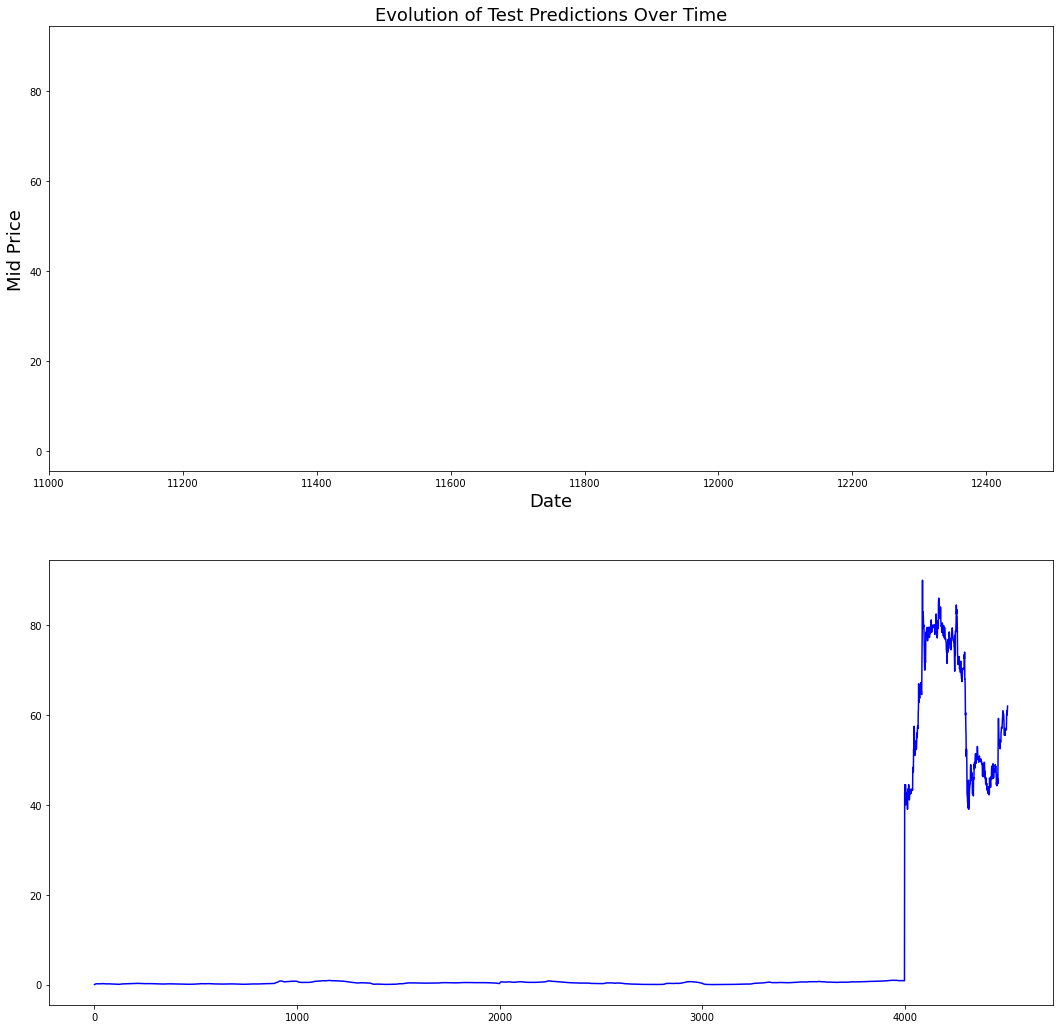

In [295]:
best_prediction_epoch = 28 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.savefig('plot.png')

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')
    
plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)
plt.show()

In [32]:
len(x_axis_seq)

20

In [33]:
len(predictions_over_time[best_prediction_epoch])

20

In [34]:
sam_predictions_over_time = list(enumerate(predictions_over_time[::3]))

In [35]:
import pandas as pd
df = pd.DataFrame(sam_predictions_over_time)
df.to_csv("sam_predictions_over_time.csv")

In [36]:
sam_seq_p = list(zip(x_axis_seq,p))

In [37]:
import pandas as pd
df = pd.DataFrame(sam_seq_p)
df.to_csv("sam_seq_p.csv")

In [38]:
(list(enumerate(predictions_over_time[::3])))

[(0, [array([0.33262891, 0.33421236, 0.33558571, 0.33672476, 0.33762717,
          0.33830369, 0.33877474, 0.33906427, 0.33919793, 0.33920088,
          0.33909607, 0.33890411, 0.33864287, 0.33832777, 0.33797163,
          0.33758497, 0.3371762 , 0.33675244, 0.33631858, 0.3358793 ,
          0.33543745, 0.33499548, 0.33455479, 0.33411673, 0.33368212,
          0.33325091, 0.33282402, 0.33240089, 0.33198157, 0.33156595,
          0.33115372, 0.33074477, 0.33033887, 0.3299354 , 0.32953489,
          0.3291367 , 0.32874042, 0.32834661, 0.32795441, 0.32756433,
          0.327176  , 0.32678941, 0.32640472, 0.32602152, 0.32564005,
          0.32526028, 0.32488203, 0.32450572, 0.32413101, 0.3237578 ]),
   array([0.25659251, 0.25723475, 0.25793824, 0.25863782, 0.25929153,
          0.25987568, 0.2603789 , 0.26079896, 0.26113889, 0.26140526,
          0.2616061 , 0.2617496 , 0.26184449, 0.26189834, 0.26191851,
          0.26191109, 0.26188165, 0.26183465, 0.26177415, 0.26170349,
          0.261

In [39]:
len(x_axis_seq)

20

Though not perfect, LSTM seems to be able to predict stock price behavior correctly most of the time. Note that you are making predictions roughly in the range of 0 and 1.0 (that is, not the true stock prices). This is okey, because you're predicting the stock price movement, not the prices themselves.

## Final Remarks

I'm hoping the readers will find this tutorial useful. I should mention that this was a rewarding experience for me. In this tutorial, I learnt how difficult it can be to device a model that is able to correctly predict stock price movements. You started with a motivation for why you need to model stock prices. This was followed by explnation and code for downloading data. Then you looked at two averaging techniques that allow us to make predictions one step into the future. You next saw that these methods are futile when you need to predict more than one step into the future. Thereafter you discussed how you can use LSTMs to make predictions many steps into the future. Finally you visualized the results and saw that our model (though not perfect) is quite good at correctly predicting stock price movements. 

Here, I'm stating serveral takeaways of this tutorial.

1. Stock price/movement prediction is an extremely difficult task. Personally I don't think any of the stock prediction models out there shouldn't be taken for granted and blidly rely on them. However models might be able to predict stock price movement correctly most of the time, but not always.

2. Do not be fooled by articles out there that shows predictions curves that perfectly overlaps the true stock prices. This can be replicated with a simple averaging technique and in practice it's useless. A more sensible thing to do is predicting the stock price movements.

3. The LSTM model hyperparameters are extremely sensitive to the results you obtain. So a very good thing to do would be run some hyperparameter optimization technique (for example, Grid search / Random search) on the hyperparameters. Below I list some of the most critical hyperparameters
 * The learning rate of the optimizer
 * Number of layers and the number of hidden units in each layer
 * The optimizer. I found Adam to perform the best
 * Type of the model. You can try GRU/ Standard LSTM/ LSTM with Peepholes and evaluation performance difference

4. In this tutorial you did something faulty (due to the small size of data)! That is you used the test loss to decay the learning rate. This indirectly leaks information about test set into the training procedure. A better way of handling this is to have a separate validation set (apart from the test set) and decay learning rate with respect to performance of the validation set.

## Author Details
* Author: Thushan Ganegedara
* Email: thushv@gmail.com
* Website: http://www.thushv.com/
* LinkedIn: https://www.linkedin.com/in/thushanganegedara/

Datacamp Tutorial: https://www.datacamp.com/community/tutorials/lstm-python-stock-market

If you find this tutorial useful, **don't forget to upvote the post at Datacamp** :)

## References

I referred the following code to get an understanding about how to use LSTMs for stock predictions. But details can be vastly different from the implementation found in the reference.

[1] https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction